In [1]:
import scanpy as sc
import pandas as pd

import seaborn as sns
from matplotlib import rcParams
import numpy as np

In [2]:
!ls -lha ../data/*

-rw-rw-r-- 1 ing ing 9.4M Nov 29 14:43 ../data/all_cells.csv
-rw-rw-r-- 1 ing ing 4.1M Nov 29 14:20 ../data/epithelial_compartment.csv
-rw-rw-r-- 1 ing ing 160K Nov 29 14:29 ../data/fibroblast_compartment.csv
-rw-rw-r-- 1 ing ing 356K Nov 29 14:38 ../data/immune_compartment.csv
-rw-rw-r-- 1 ing ing 1.7G Nov 29 13:05 ../data/MIBC_snSeq.h5ad
-rw-rw-r-- 1 ing ing 2.1M Nov 29 16:15 ../data/non_tumor_all_cells.csv
-rw-rw-r-- 1 ing ing 918K Nov 29 16:33 ../data/non_tumor_epithelial_compartment.csv
-rw-rw-r-- 1 ing ing 304M Nov 29 16:15 ../data/non_tumor_snSeq.h5ad


In [3]:
!md5sum ../data/*

66b991da2983dc7e19a5913d38daa78e  ../data/all_cells.csv
f2778dcb9c9d88fe7ee29ab6df3906db  ../data/epithelial_compartment.csv
4b52e9ad8ae2e03a8a6dba729859a739  ../data/fibroblast_compartment.csv
5c06539ba6409c84f8808e381c0e5d14  ../data/immune_compartment.csv
b5affa11fca0f9ca461ca0408530cd21  ../data/MIBC_snSeq.h5ad
0b7beee075374e03bb5ea2a1f3b2775e  ../data/non_tumor_all_cells.csv
ac55aeaaf23fdc168c38b9fa66f202da  ../data/non_tumor_epithelial_compartment.csv
dd35d700e909d46f081b699690de7e88  ../data/non_tumor_snSeq.h5ad


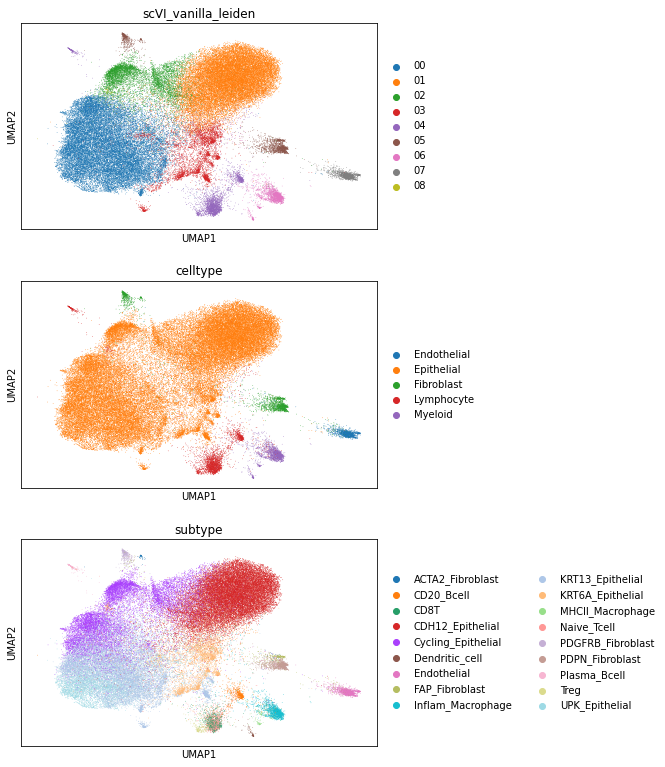

In [4]:
ad = sc.read_h5ad("../data/MIBC_snSeq.h5ad")
obs = pd.read_csv("../data/all_cells.csv", index_col=0, header=0)
sc.pp.normalize_total(ad, target_sum=10000)
sc.pp.log1p(ad)

ad.obsm['X_umap'] = obs.loc[:, ['umap_1', 'umap_2']].values
sc.pl.umap(ad, color=['scVI_vanilla_leiden', 'celltype', 'subtype'], ncols=1)

In [9]:
ad

AnnData object with n_obs × n_vars = 67988 × 33538
    obs: 'subtype', 'initial_celltype', 'scVI_vanilla_leiden', 'celltype', 'hash_ID', 'batch', 'Patient'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'scVI_args', 'log1p', 'scVI_vanilla_leiden_colors', 'celltype_colors', 'subtype_colors', 'rank_genes_groups'
    obsm: 'X_umap'

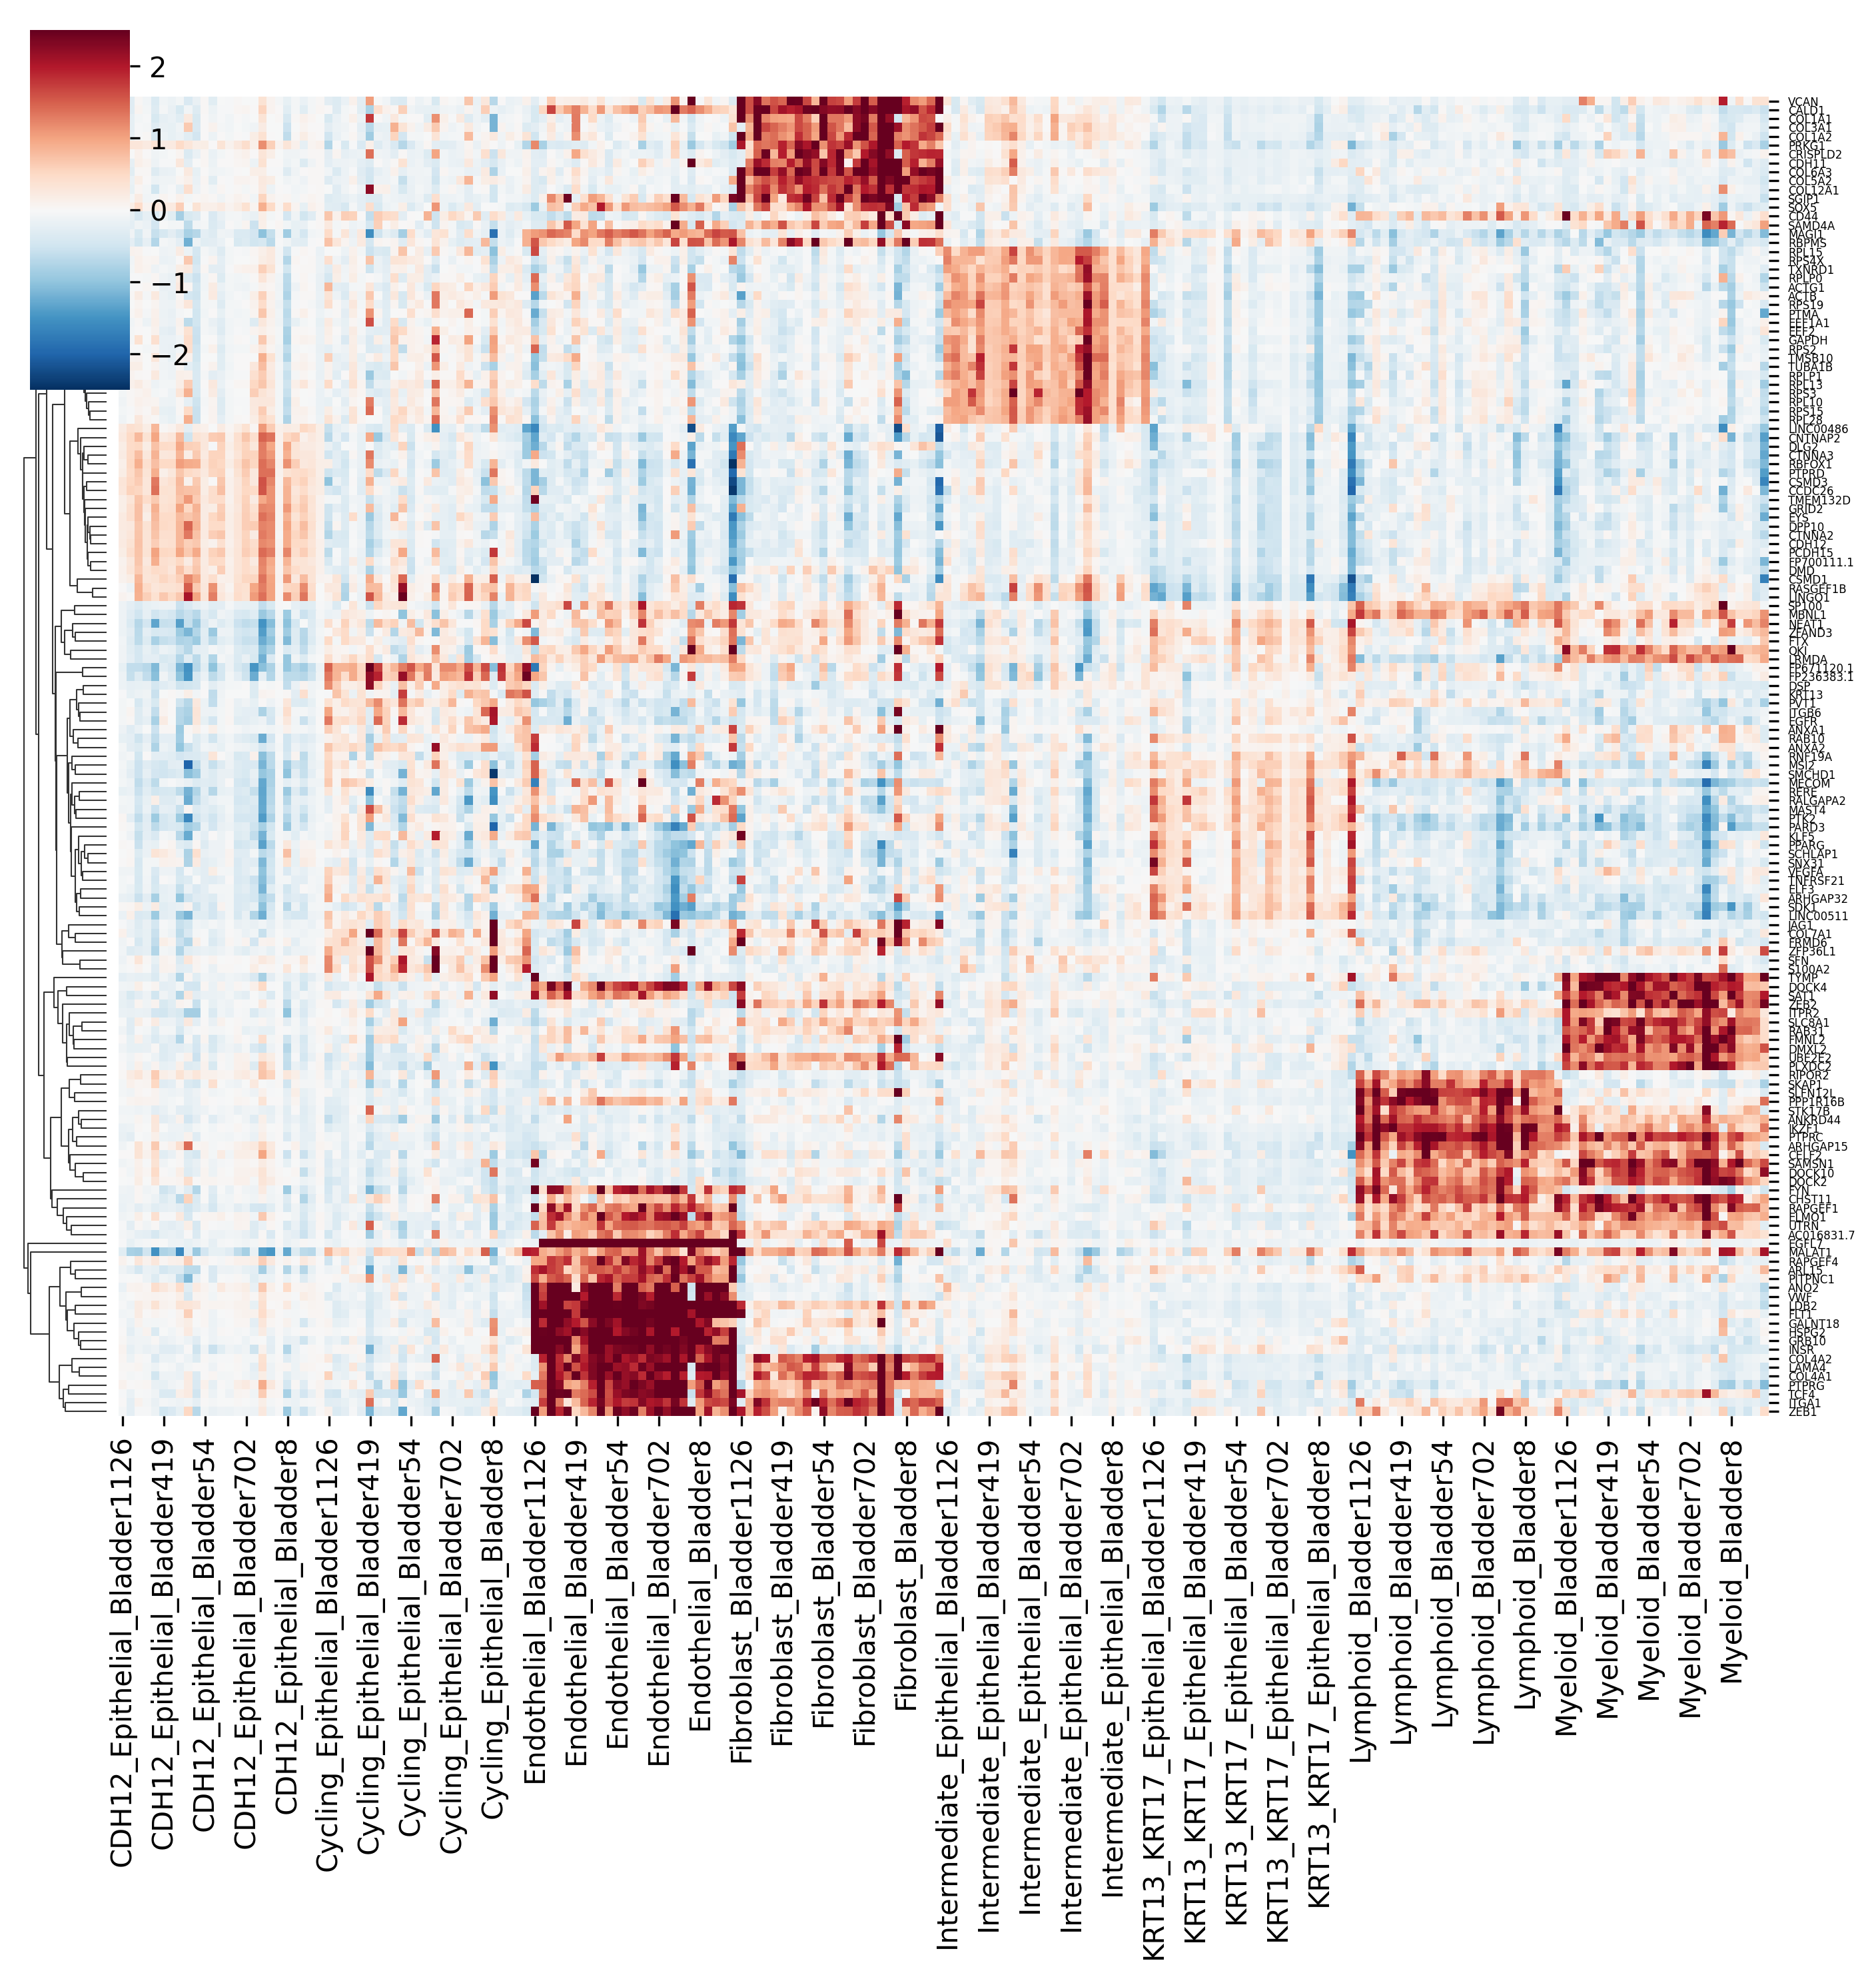

In [10]:

sc.tl.rank_genes_groups(ad, method='wilcoxon', groupby='initial_celltype', n_genes=20)
marker_genes = []
for group in np.unique(ad.obs.initial_celltype):
    df = sc.get.rank_genes_groups_df(ad, group)
    df = df.query('pvals_adj < 0.05')
    df['initial_celltype'] = [group]*df.shape[0]
    marker_genes.append(df.copy())
    
marker_genes = pd.concat(marker_genes, axis=0)
marker_genes = marker_genes.drop_duplicates(subset='names', keep='first')

gex = []
for pt in np.unique(ad.obs.Patient):
    ad_pt = ad[ad.obs.Patient==pt, ad.var_names.isin(marker_genes.names)].copy()
    sc.pp.scale(ad_pt, zero_center=True)
    gex_pt = pd.DataFrame(ad_pt.X, index=ad_pt.obs_names, columns=ad_pt.var_names)
    gex_pt['cluster'] = ad_pt.obs['initial_celltype']
    gex_pt = gex_pt.groupby('cluster').mean()
    gex_pt.index = [f'{i}_{pt}' for i in gex_pt.index]
    gex.append(gex_pt.copy())
    
gex = pd.concat(gex, axis=0)
gex = gex.sort_index()

rcParams['figure.dpi'] = 300
ax = sns.clustermap(gex.T, z_score=None, cmap='RdBu_r', col_cluster=False, vmax=2.5, vmin=-2.5, 
                    yticklabels=True, dendrogram_ratio=0.05,
                   )
_ = ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), fontsize=4)